# Geodesic Distance in fsLR-5k  |  Euclidean Distance Matrix (EDM)

# Euclidean Distance Matrix (EDM)
## Get center of mass
```bash
3dCM -all_rois sub-PNC001_ses-01_space-nativepro_T1w_atlas-schaefer-100.nii.gz > schaefer-100.txt
```

## Sort center of mass `txt` remove AFNI text
```bash
sed -e 1d schaefer-100.txt | sed -e ':a' -e 'N' -e '$!ba' -e 's/\n/ /g' | sed -e 's/#ROI /\n/g' | sed -e 1d > tmp.txt && mv tmp.txt schaefer-100.txt
```

## Sort `txt` into a `numpy` readable matrix
```bash
# replace double blank space with one blank space
sed -i 's/  / /g' schaefer-100.txt

# replace blanck space with comma
sed -i 's/ /,/g' schaefer-100.txt

# remove last character from each line ','
sed -i 's/.$//' schaefer-100.txt
```

## Shall I include the voxel resolution to the distance matrix?

# Get the center of mass

In [ ]:
%%time
%%bash
# change working directory
cd /data_/mica3/BIDS_PNI/derivatives_dev/micapipe_v0.2.0/sub-PNC001/ses-01/anat/volumetric

# Calculate center of mass
atlas="schaefer-1000"
3dCM -all_rois sub-PNC001_ses-01_space-nativepro_T1w_atlas-${atlas}.nii.gz > ${atlas}.txt

# Sort `txt` into a `numpy` readable file

In [ ]:
%%time
%%bash
atlas=schaefer-1000
CM=/data_/mica3/BIDS_PNI/derivatives_dev/micapipe_v0.2.0/sub-PNC001/ses-01/anat/volumetric/${atlas}.txt
sed -e 1d ${CM} | sed -e ':a' -e 'N' -e '$!ba' -e 's/\n/ /g' | sed -e 's/#ROI /\n/g' | sed -e 1d > tmp.txt && mv tmp.txt ${CM}

sed -e 's/  / /g' ${CM} | sed -e 's/ /,/g' | sed -e 's/.$//' > tmp.txt && mv tmp.txt ${CM}

In [17]:
# libraries
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as mpl
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_conte69
from brainspace.datasets.base import load_mask
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
import pygeodesic
import pygeodesic.geodesic as geodesic
import nibabel as nb
import vtk
# from vtk_helpers import *
# Note: vtk_helpers module can be found in examples folder where pygeodesic module is located.

# functions
def getPointsAndCellsFromPolydata(polydata):
    """
    Extract points and cells from polydata object
    Args:
        polydata (vtk.vtkPolyData): polydata object representing mesh
    
    Returns:
        ndarray: Array of points
        ndarrdy: Array of cells
    """    
    
    # Use numpy wrapper to easily extract points and cells
    polydata = dsa.WrapDataObject(polydata) if isinstance(polydata, vtk.vtkPolyData) else polydata

    # Get points
    points = np.array(polydata.GetPoints(), dtype=np.float64)

    # Get cells
    polygons = np.array(polydata.GetPolygons(), dtype=np.int32)
    n = polygons[0]+1
    polygons = np.resize(polygons, (polygons.size//n, n))
    polygons = polygons[:, 1:n]
    
    return points, polygons

def plot_connectome(mtx, Title='matrix plot', xlab='X', ylab='Y', col='rocket', Vmin=None, Vmax=None):
    '''
    This optional function, only plots a connectome as a heatmap
    Parameters
    ----------
    mtx : np.array
    Returns
    -------
    f : plot
    '''
    f, ax = mpl.subplots(figsize=(15,10))
    g = sns.heatmap(mtx, ax=ax, cmap=col, vmin=Vmin, vmax=Vmax)
    g.set_xlabel(xlab)
    g.set_ylabel(ylab)
    g.set_title(Title)

def mask_array(data, mask):
    # replace 0|False values with nan
    data_masked = np.copy(data)
    if mask.dtype == 'bool':
        data_masked[:,mask == False] = 'nan'
    elif mask.dtype == 'int':
        data_masked[:,mask == 0] = 'nan'
    return(data_masked)    

# variables
micapipe='/data_/mica1/01_programs/micapipe-v0.2.0'
derivatives='/data_/mica3/BIDS_MICs/derivatives'
out=derivatives+ '/micapipe_v0.2.0/'
sub='sub-HC062'
subjectID=sub+'_ses-01'
subjectDir=out + sub+'/ses-01'

# conte 69 surfaces
c69_lh, c69_rh = load_conte69()
c69_mask = load_mask(join=True)
c69_lhi = read_surface(micapipe + '/surfaces/fsLR-32k.L.inflated.surf.gii', itype='gii')
c69_rhi = read_surface(micapipe + '/surfaces/fsLR-32k.R.inflated.surf.gii', itype='gii')

# Read fsLR-5k surfaces
c5k_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.surf.gii', itype='gii')
c5k_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.surf.gii', itype='gii')
c5k_lhi = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
c5k_rhi = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

# Load native pial surface
def load_surf(label='pial', surf='fsnative'):
    gm_lh = read_surface(subjectDir+'/surf/'+subjectID+'_hemi-L_space-nativepro_surf-'+surf+'_label-'+label+'.surf.gii', itype='gii')
    gm_rh = read_surface(subjectDir+'/surf/'+subjectID+'_hemi-R_space-nativepro_surf-'+surf+'_label-'+label+'.surf.gii', itype='gii')
    return (gm_lh, gm_rh)

def mask_array(data, mask):
    # replace 0|False values with nan
    data_masked = np.copy(data)
    if mask.dtype == 'bool':
        data_masked[mask == False] = 'nan'
    elif mask.dtype == 'int':
        data_masked[mask == 0] = 'nan' # data_masked[:,mask == 0]
    return(data_masked)


# Euclidean Distance Matrix: both hemispheres 

In [2]:
%%time
atlas='schaefer-1000'
coord = np.loadtxt('/data_/mica3/BIDS_PNI/derivatives_dev/micapipe_v0.2.0/sub-PNC001/ses-01/anat/volumetric/'+atlas+'.txt',delimiter=",")
ED = np.array([ np.linalg.norm(coord[2:,1:4] - p, axis=1) for p in coord[2:,1:4]])

## Remove the Mediall Wall
Ndim=500
ED = np.delete(np.delete(ED, Ndim, axis=0), Ndim, axis=1)

CPU times: user 78.8 ms, sys: 16.3 ms, total: 95 ms
Wall time: 310 ms


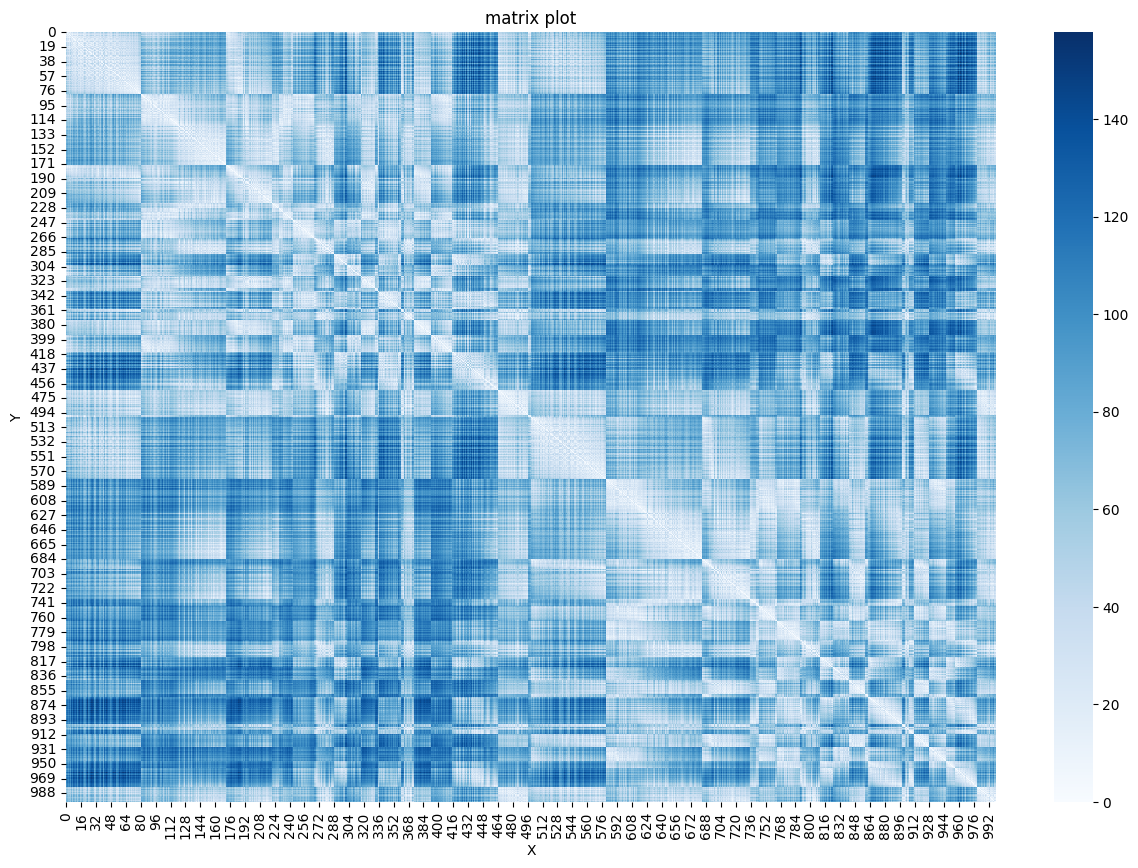

In [3]:
plot_connectome(ED, col='Blues')

In [4]:
# Variables for schaeffer-400
atlas='schaefer-400'
coord = np.loadtxt('/data_/mica3/BIDS_PNI/derivatives_dev/micapipe_v0.2.0/sub-PNC001/ses-01/anat/volumetric/'+atlas+'.txt',delimiter=",")

# Read label for conte69
labels_c69 = np.loadtxt(open(micapipe + '/parcellations/' + atlas + '_conte69.csv'), dtype=int)


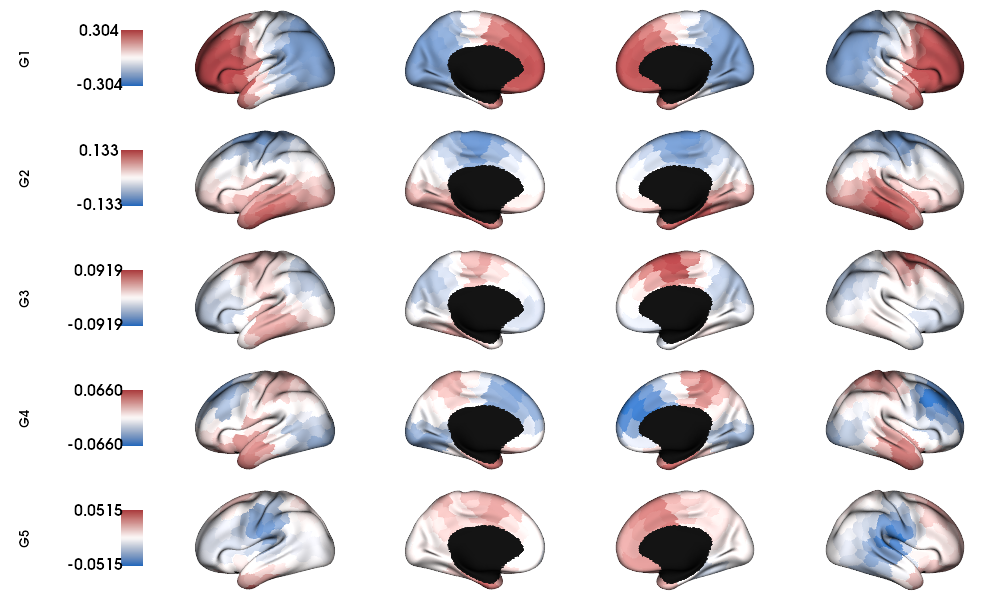

In [5]:
# Euclidean distand gradient
ED = np.array([ np.linalg.norm(coord[2:,1:4] - p, axis=1) for p in coord[2:,1:4]])
# Remove the Mediall Wall
ED = np.array([ np.linalg.norm(coord[2:,1:4] - p, axis=1) for p in coord[2:,1:4]])
Ndim=200
ED = np.delete(np.delete(ED, Ndim, axis=0), Ndim, axis=1)

Ngrad=5
S=0.8
gm_ED_L = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel='normalized_angle')
gm_ED_L.fit(ED[0:Ndim, 0:Ndim], sparsity=S)

# ED Right hemi
gm_ED_R = GradientMaps(n_components=Ngrad, alignment='procrustes', kernel='normalized_angle'); # align right hemi to left hemi
gm_ED_R.fit(ED[Ndim:Ndim*2, Ndim:Ndim*2], sparsity=0.8, reference=gm_ED_L.gradients_)

# Left and right gradients concatenated
ED_gradients = np.concatenate((gm_ED_L.gradients_, gm_ED_R.aligned_), axis=0)

# Map gradients to original parcels
grad = [None] * Ngrad
for i, g in enumerate(ED_gradients.T[0:Ngrad,:]):
         grad[i] = map_to_labels(g, labels_c69, fill=np.nan, mask=c69_mask)

# Plot Gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(c69_lhi, c69_rhi, array_name=grad, size=(1000, 600), cmap='vlag',
                      embed_nb=True,  label_text={'left':labels}, color_bar='left',
                      zoom=1.5, nan_color=(0, 0, 0, 1), color_range='sym')

# Vertex-wise Geodesic Distance on fsLR-5k

In [6]:
%%time
gm_lh, gm_rh = load_surf(label='pial', surf='fsLR-5k')
# LEFT: Initialise the PyGeodesicAlgorithmExact class instance
points, faces = getPointsAndCellsFromPolydata(gm_lh)
geoalg = geodesic.PyGeodesicAlgorithmExact(points,faces)

N = 4842
GD = np.empty((N,N), dtype=float)
for x in range(0,N,1):
    distances, best_source = geoalg.geodesicDistances(np.array([x]))
    GD[x,:] = distances
    
# Initialise the PyGeodesicAlgorithmExact class instance
points, faces = getPointsAndCellsFromPolydata(gm_rh)
geoalg = geodesic.PyGeodesicAlgorithmExact(points,faces)

# calculate matrix
GD_r = np.empty((N,N), dtype=float)
for x in range(0,N,1):
    distances, best_source = geoalg.geodesicDistances(np.array([x]))
    GD_r[x,:] = distances

CPU times: user 5min 58s, sys: 245 ms, total: 5min 59s
Wall time: 6min


In [14]:
# save GD connectomes
np.save(subjectID+'_hemi-L_surf-fsLR-5k_desc-GD.npy', GD)
np.savetxt(subjectID+'_hemi-L_surf-fsLR-5k_desc-GD.txt', GD)

np.save(subjectID+'_hemi-R_surf-fsLR-5k_desc-GD.npy', GD_r)
np.savetxt(subjectID+'_hemi-R_surf-fsLR-5k_desc-GD.txt', GD_r)

CPU times: user 9.96 s, sys: 778 ms, total: 10.7 s
Wall time: 10.8 s


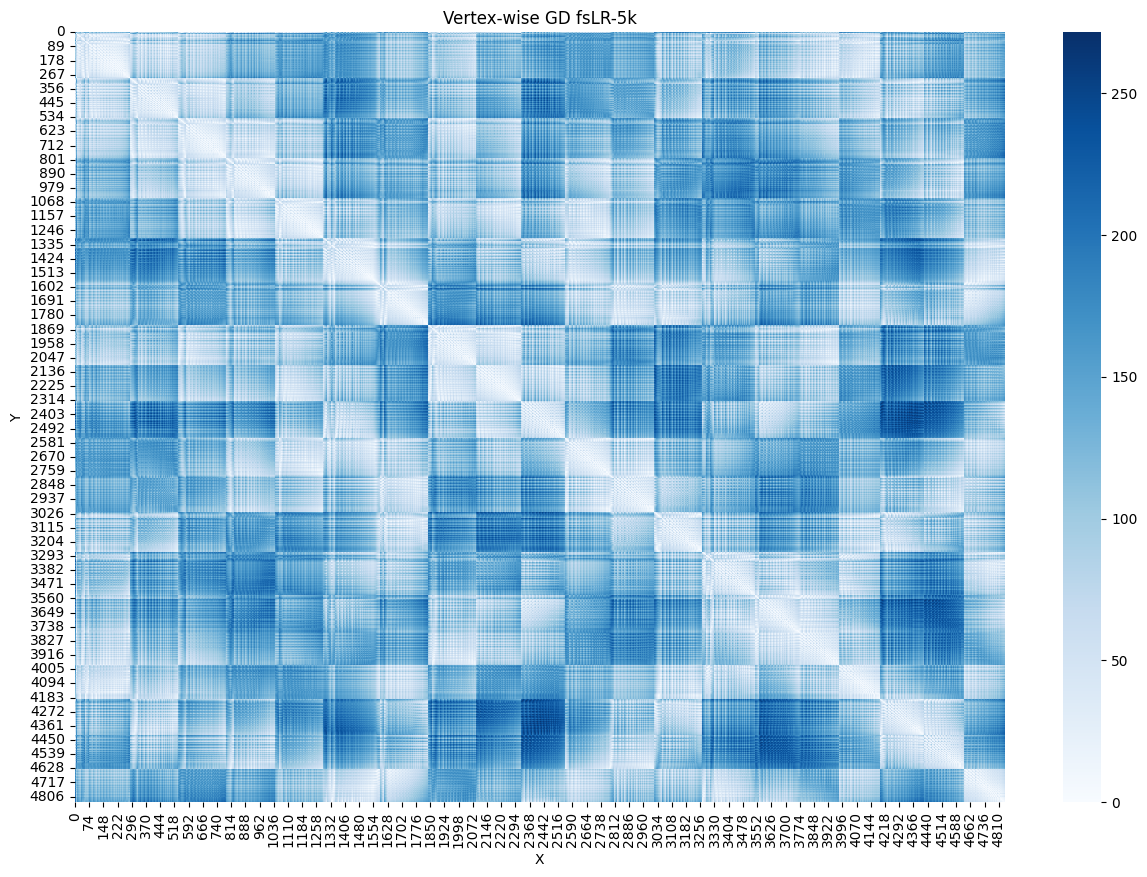

In [7]:
%%time
plot_connectome(GD, col='Blues', Title='Vertex-wise GD fsLR-5k')

## Load the data from here:

In [12]:
%%bash
ls -lashS *GD.*

559M -rw-rw---- 1 rcruces mica 559M Mar  9 02:55 sub-HC062_ses-01_hemi-L_surf-fsLR-5k_desc-GD.txt
559M -rw-rw---- 1 rcruces mica 559M Mar  9 02:55 sub-HC062_ses-01_hemi-R_surf-fsLR-5k_desc-GD.txt
179M -rw-rw---- 1 rcruces mica 179M Mar  9 02:55 sub-HC062_ses-01_hemi-L_surf-fsLR-5k_desc-GD.npy
179M -rw-rw---- 1 rcruces mica 179M Mar  9 02:55 sub-HC062_ses-01_hemi-R_surf-fsLR-5k_desc-GD.npy


In [13]:
GD = np.loadtxt('sub-HC062_ses-01_hemi-L_surf-fsLR-5k_desc-GD.txt',dtype=float)
GD_r = np.loadtxt('sub-HC062_ses-01_hemi-R_surf-fsLR-5k_desc-GD.txt',dtype=float)

In [14]:
%%bash
ls /data/mica1/01_programs/micapipe-v0.2.0/surfaces/*fsLR-5k*mask.shape.gii

/data/mica1/01_programs/micapipe-v0.2.0/surfaces/fsLR-5k.L.mask.shape.gii
/data/mica1/01_programs/micapipe-v0.2.0/surfaces/fsLR-5k.R.mask.shape.gii


In [18]:
# Load the mask of the medial wall
#mask_lh = np.loadtxt('/data_/mica3/BIDS_MICs/fsLR_5k/surface/deformed_mask_5k_lh.txt',dtype=int)
#mask_rh = np.loadtxt('/data_/mica3/BIDS_MICs/fsLR_5k/surface/deformed_mask_5k_rh.txt',dtype=int)
mask_lh = nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_rh = nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data

# Concatenate both masks left and right
mask_fsRL10k = np.concatenate((mask_lh, mask_rh), axis=0)
# map_to_labels will use a boolean array as input
mask = mask_fsRL10k != 0

# Labels and boolean mask
labels_fsRL10k = np.array(range(mask_fsRL10k.shape[0]))

# DM embedding full matrix

In [33]:
%%time
Ngrad=5
S=0.8
gm_GD = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel='normalized_angle')
gm_GD.fit(GD, sparsity=S)

gm_GD_r = GradientMaps(n_components=Ngrad, alignment='procrustes', kernel='normalized_angle'); # align right hemi to left hemi
gm_GD_r.fit(GD_r, sparsity=0.8, reference=gm_GD.gradients_)

# Left and right gradients concatenated
GD_gradients = np.concatenate((gm_GD.gradients_, gm_GD_r.aligned_), axis=0)

# Map gradients to original parcels
grad = [None] * Ngrad
for i, g in enumerate(GD_gradients.T[0:Ngrad,:]):
     grad[i] = mask_array(g, mask)

CPU times: user 1min 30s, sys: 2.35 s, total: 1min 32s
Wall time: 1min 24s


In [34]:
# Plot Gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(c5kr_lh, c5kr_rh, array_name=grad, size=(1000, 600), cmap='vlag',
                embed_nb=True,  label_text={'left':labels}, color_bar='left',
                zoom=1.5, nan_color=(0, 0, 0, 1), color_range='sym', transparent_bg=False,
                screenshot=True, filename='/host/yeatman/local_raid/rcruces/fsLR-5k_GD.png')

'/host/yeatman/local_raid/rcruces/fsLR-5k_GD.png'

# DM embedding removing medial wall

In [30]:
# Get the index of the non medial wall regions
indx = np.where(mask_lh==1)[0]

# Slice the matrix
GDl_m = GD[indx, :]
GDl_m = GDl_m[:, indx]

# Slice the matrix
GDr_m = GD_r[indx, :]
GDr_m = GDr_m[:, indx]

Ngrad=5
S=0.8
gm_GD = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel='normalized_angle')
gm_GD.fit(GDl_m, sparsity=S)

gm_GD_r = GradientMaps(n_components=Ngrad, alignment='procrustes', kernel='normalized_angle'); # align right hemi to left hemi
gm_GD_r.fit(GDr_m, sparsity=0.8, reference=gm_GD.gradients_)

# Left and right gradients concatenated
GD_gradients = np.concatenate((gm_GD.gradients_, gm_GD_r.aligned_), axis=0)

# Map gradients to original parcels
grad = [None] * Ngrad
for i, g in enumerate(GD_gradients.T[0:Ngrad,:]):
     grad[i] = map_to_labels(g, labels_fsRL10k, fill=np.nan, mask=mask)

In [32]:
# Plot Gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(c5kr_lh, c5kr_rh, array_name=grad, size=(1000, 600), cmap='vlag',
                embed_nb=True,  label_text={'left':labels}, color_bar='left',
                zoom=1.5, nan_color=(0, 0, 0, 1), color_range='sym',transparent_bg=False,
                screenshot=True, filename='/host/yeatman/local_raid/rcruces/fsLR-5k_GD-masked.png')

'/host/yeatman/local_raid/rcruces/fsLR-5k_GD-masked.png'